In [1]:
import sys
sys.path.append("../../nonspin/")

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from waveform import SingleModeNRWaveform

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

In [2]:
matplotlib.rcParams.update({'font.size': 18})

# helper

In [3]:

def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [4]:
def planck_taper(x, x1, x2):
    taper = np.zeros(len(x))
    
    mask_ones = x >= x2
    taper[mask_ones] = 1.
    
    mask = (x > x1) & (x < x2)

    # overflow :(
    taper[mask] = 1. / (np.exp( (x2-x1)/(x[mask]-x1) + (x2-x1)/(x[mask]-x2) ) + 1.)
    
    return taper

In [173]:
# from: positive/physics.py, returns orbital angular frequency
# PN estimate for orbital frequency
def pnw0(m1,m2,D=10.0):
    # https://arxiv.org/pdf/1310.1528v4.pdf
    # Equation 228
    # 2nd Reference: arxiv:0710.0614v1
    # NOTE: this outputs orbital frequency
    from numpy import sqrt,zeros,pi,array,sum
    #
    G = 1.0
    c = 1.0
    r = float(D)
    M = float( m1+m2 )
    v = m1*m2/( M**2 )
    gamma = G*M/(r*c*c)     # Eqn. 225
    #
    trm = zeros((4,))
    #
    trm[0] = 1.0
    trm[1] = v - 3.0
    trm[2] = 6 + v*41.0/4.0 + v*v
    trm[3] = -10.0 + v*( -75707.0/840.0 + pi*pi*41.0/64.0 ) + 19.0*0.5*v*v + v*v*v
    #
    w0 = sqrt( (G*M/(r*r*r)) * sum( array([ term*(gamma**k) for k,term in enumerate(trm) ]) ) )

    #
    return w0

In [238]:
import glob
import os

In [240]:
os.path.dirname(bam_file)

'/Users/spx8sk/work/data/q18a0a0c025_144'

In [245]:
glob.glob( os.path.join(os.path.dirname(bam_file), '*.bbh'))[0]

'/Users/spx8sk/work/data/q18a0a0c025_144/q18a0a0c025_144.bbh'

In [291]:
import configparser

bbh_file = "/Users/spx8sk/work/data/q18a0a0c025_144/q18a0a0c025_144.bbh"
# bam_file = "/Users/spx8sk/work/data/q18a0a0c025_144/psi3col.r9.l4.l2.m2"
bam_file = "/Users/spx8sk/work/data/q18a0a0c025_144/psi3col.r7.l5.l2.m2"

class Load_BAM_data(object):
    def __init__(self, nrfile, bbh_file, npts, t1=None, t2=None):
        self.nrfile = nrfile
        
        if bbh_file is None:
            # search for it
            self.sim_dir = os.path.dirname(self.nrfile)
            self.bbh_file = glob.glob( os.path.join(self.sim_dir, '*.bbh'))[0]
        else:            
            self.bbh_file = bbh_file
        self.npts = npts
        self.t1=t1
        self.t2=t2

        self.get_BAM_22_mode(self.nrfile, self.bbh_file, self.npts)


    def get_BAM_22_mode(self, nrfile, bbh_file, npts):
        
        # strict=False because of DuplicateSectionError
        config = configparser.ConfigParser(strict=False)

        config.read(bbh_file)
#         config.sections()
        
#         for k in config['metadata']:
#             print(k)
        
        mass1_tmp = float(config['metadata']['mass1'])
        mass2_tmp = float(config['metadata']['mass2'])
        self.initial_sep = float(config['metadata']['initial-separation'])
        
        if mass1_tmp >= mass2_tmp:
            mass1 = mass1_tmp
            mass2 = mass2_tmp
        else:
            mass1 = mass2_tmp
            mass2 = mass1_tmp
        
        
        self.mass1 = mass1
        self.mass2 = mass2
        self.mtot = self.mass1 + self.mass2
        self.q = self.mass1 / self.mass2
        self.eta = self.mass1 * self.mass2 / (self.mtot)**2.

        times, re_psi4, im_psi4 = np.loadtxt(nrfile, unpack=True)
        
        # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
        psi4 = re_psi4 + 1.j * im_psi4
        amp = np.abs(psi4)
        phase = np.unwrap(np.angle(psi4))

        max_idx = amp.argmax()
        max_time = times[max_idx]
        times = times - max_time
        
        amp_i = IUS(times, amp)
        phase_i = IUS(times, phase)

        if self.t1 is None:
            self.t1 = times[0]
        if self.t2 is None:
            self.t2 = times[-1]

        # t1,t2=-600,100

        common_times = np.linspace(self.t1, self.t2, npts)

        amplist = amp_i(common_times)
        phaselist = phase_i(common_times)

        self.times = common_times
        self.amp = amplist
        self.phi = phaselist
        # self.hlm["{0}, {1}".format(ell, mm)] = self.amp * np.exp(-1.j * self.phi)
        self.psi4 = self.amp * np.exp(-1.j * self.phi)
        
#         taper = planck_taper(self.times, -1000, -999)

#         this with om_zero = 0.07 is very similar to the BAM results
        t1 = -950
#         t2 = t1 + 50
        t2 = t1 + 150
#         t1 = -850
#         t2 = t1 + 100
        
        te1 = 90
        te2 = te1 + 50

        self.taper = planck_taper(self.times, t1, t2)
        self.taper_end = planck_taper(self.times, te1, te2)
        
        self.psi4_no_taper = self.psi4
        self.psi4 = self.psi4 * self.taper * (1-self.taper_end)
        
        self.phase_derivative = phase_i.derivative()(common_times)
        
        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
        
        
        
    def compute_strain_ffi(self, om_zero, fudge_om_zero=0.9):
        
        
        if om_zero is None:
            self.om_zero = pnw0(self.mass1, self.mass2, D=self.initial_sep) * 2 # times 2 for m=2 GW mode.
            self.fudge_om_zero = fudge_om_zero
            self.om_zero *= self.fudge_om_zero
        else:
            self.om_zero = om_zero
        
        self.psi4_fft = np.fft.fft(self.psi4)
        self.dt = self.times[1] - self.times[0]
        self.freq = np.fft.fftfreq(len(self.times), self.dt)
        self.freq_om = self.freq * 2. * np.pi
        
        self.freq_om_ffi = self.freq_om.copy()

        self.freq_om_ffi[(self.freq_om_ffi > -self.om_zero) & (self.freq_om_ffi <= 0)] = -self.om_zero
        self.freq_om_ffi[(self.freq_om_ffi < self.om_zero)  & (self.freq_om_ffi > 0)] = self.om_zero
    
        self.news_lm_fd = (-1.j * self.psi4_fft / self.freq_om_ffi)
        self.hlm_fd = (-1.j * self.news_lm_fd / self.freq_om_ffi)
        
        self.hlm_ifft = np.fft.ifft(self.hlm_fd)
        self.hlm = self.hlm_ifft
        
#         self.freq_ffi = self.freq[self.mask_no_DC] = om_zero

In [292]:
# for ii in range(0, fr.Length()):
#     if (fr.x[ii] != 0):
#         #if fr.x[ii] < 0: fr.f[ii] = 0
#         div = 2*pi*fr.x[ii]
#         if abs(fr.x[ii]) < abs(f0): div = 2*pi*abs(f0)*sign(fr.x[ii])
#         fr.f[ii] = complex(0.,1.)**k * fr.f[ii]/(div**k)

#     else:
#         fr.f[ii] = 0

# res = fr.InverseFourierTransform()  

In [248]:
# bam_data = Load_BAM_data(nrfile=bam_file, bbh_file=bbh_file, npts=5000)
bam_data = Load_BAM_data(nrfile=bam_file, bbh_file=None, npts=5000)
# bam_data.compute_strain_ffi(om_zero=0.07)
# bam_data.compute_strain_ffi(om_zero=0.0805*0.9)
# bam_data.compute_strain_ffi(om_zero=0.0796*0.9)
bam_data.compute_strain_ffi(om_zero=None)

# bam_data.compute_strain_ffi(om_zero=0.06)

bam_data_2 = Load_BAM_data(nrfile=bam_file, bbh_file=bbh_file, npts=5000)
bam_data_2.compute_strain_ffi(om_zero=0.01)

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [249]:
bam_data.final_mass

0.9958625509692023

In [250]:
bam_data.fin_spin

0.16288581446090009

In [251]:
bam_data.fring

0.06333460185061178

In [252]:
1./bam_data.fdamp / 2. / np.pi

11.255711435422901

In [253]:
bam_data.phase_derivative[0]

-0.0015024257257789941

In [254]:
idx_half_time = int(half_time/dt)
print(idx_half_time)

2499


In [255]:
early_peak

532

estimate of start time, post junk = -807.2301269257598 M


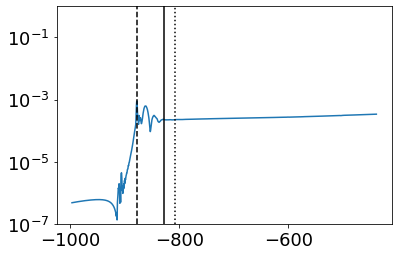

In [256]:
plt.figure()


half_time = ((bam_data.times[-1] - bam_data.times[0])/2)
dt = bam_data.times[1] - bam_data.times[0]
idx_half_time = int(half_time/dt)
mask = bam_data.times < bam_data.times[idx_half_time]

idx_early_peak = np.abs(bam_data.psi4_no_taper)[mask].argmax()
time_of_early_peak = bam_data.times[mask][idx_early_peak]
early_peak_width_approx = 50
t_damp = 1./bam_data.fdamp

clean_start_time_estimate = time_of_early_peak + t_damp
print("estimate of start time, post junk = {} M".format(clean_start_time_estimate))


plt.plot(bam_data.times[mask], np.abs(bam_data.psi4_no_taper)[mask])
plt.axvline(time_of_early_peak, c='k', ls='--')
plt.axvline(time_of_early_peak + early_peak_width_approx, c='k', ls='-')
plt.axvline(time_of_early_peak + t_damp, c='k', ls=':')
plt.ylim(1e-7, 1)
plt.yscale('log')

In [257]:
pnw0(bam_data.mass1, bam_data.mass2, D=bam_data.initial_sep) * 2

0.07963734190581367

In [258]:
def average_freq_over_range(t, f_func, window=50):
    win2 = window/2
    x = np.linspace(t-win2, t+win2, 100)
    fs = f_func(x)
    return np.mean(fs)
    

In [259]:
# av = average_freq_over_range(clean_start_time_estimate, iphi)
av = average_freq_over_range(time_of_early_peak, iphi)
print(av)

0.06893993494018795


In [260]:
iphi = IUS(bam_data.times, bam_data.phase_derivative)
iphi(clean_start_time_estimate)

array(-0.08803208)

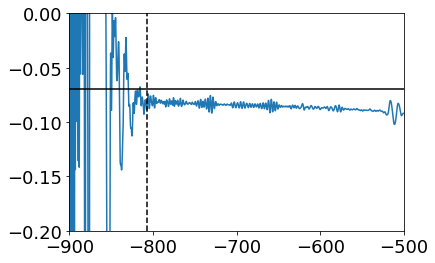

In [261]:
plt.figure()
plt.plot(bam_data.times, bam_data.phase_derivative)
plt.ylim(-0.2,0.)
plt.xlim(-900, -500)
plt.axhline(-0.07, color='k')
plt.axhline(av, color='k', ls=':')
plt.axvline(clean_start_time_estimate, color='k', ls='--')

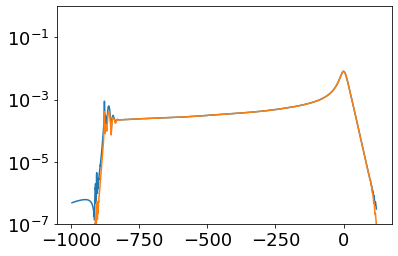

In [262]:
plt.figure()
plt.plot(bam_data.times, np.abs(bam_data.psi4_no_taper))

plt.plot(bam_data.times, np.abs(bam_data.psi4))


# taper = planck_taper(bam_data.times, bam_data.times[0]+200, bam_data.times[0] + 450)
# taper = planck_taper(bam_data.times, -825, -800)
# taper_end = planck_taper(bam_data.times, 90, 100)
# plt.plot(bam_data.times, np.abs(bam_data.psi4) * taper * (1-taper_end))

# plt.xlim(-900, -700)
# plt.xlim(0, 200)
plt.ylim(1e-7, 1)
plt.yscale('log')

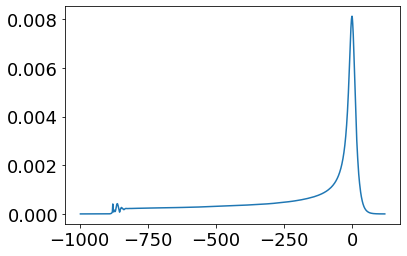

In [263]:
plt.figure()
plt.plot(bam_data.times, np.abs(bam_data.psi4))

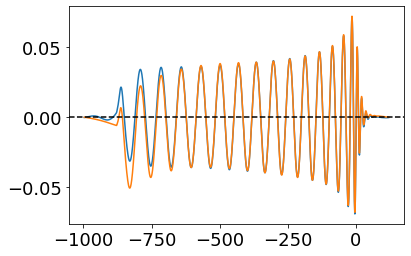

In [264]:
plt.figure()
# plt.plot(bam_data.times[:-1], np.real(bam_data.hlm_ifft))
# plt.plot(bam_data_2.times[:-1], np.real(bam_data_2.hlm_ifft))
plt.plot(bam_data.times, np.real(bam_data.hlm_ifft))
plt.plot(bam_data_2.times, np.real(bam_data_2.hlm_ifft))
plt.axhline(0, c='k', ls='--')

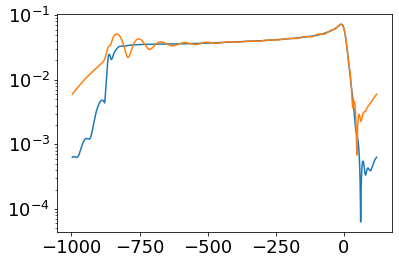

In [265]:
plt.figure()
# plt.plot(bam_data.times[:-1], np.abs(bam_data.hlm_ifft))
# plt.plot(bam_data_2.times[:-1], np.abs(bam_data_2.hlm_ifft))
plt.plot(bam_data.times, np.abs(bam_data.hlm_ifft))
plt.plot(bam_data_2.times, np.abs(bam_data_2.hlm_ifft))
plt.yscale('log')
# plt.xlim(-100, 100)
# plt.ylim(1e-3,1e-1)

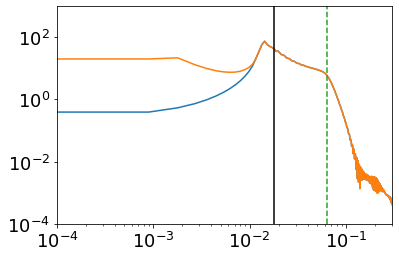

In [266]:
plt.figure()
# plt.plot(bam_data.freq[bam_data.mask_no_DC], np.abs(bam_data.hlm_fd))
# plt.plot(bam_data_2.freq[bam_data_2.mask_no_DC], np.abs(bam_data_2.hlm_fd))
plt.plot(bam_data.freq, np.abs(bam_data.hlm_fd))
plt.plot(bam_data_2.freq, np.abs(bam_data_2.hlm_fd))
plt.yscale('log')
plt.xscale('log')
# plt.xlim(-0.2,0.2)
plt.xlim(1e-4, 0.3)
# plt.xlim(-0.02,0.02)
plt.ylim(1e-4,1e3)
plt.axvline(0.018, color='k')

plt.axvline(bam_data.fring, color='C2', ls='--')

In [267]:
# load bam hlm 22 mode
h3col_bam_file = "/Users/spx8sk/work/data/q18a0a0c025_144/h3col.r7.l5.l2.m2"
h3col_t, h3col_hre, h3col_him = np.loadtxt(h3col_bam_file, unpack=True)

In [268]:
np.abs(bam_data.hlm_ifft).argmax()

4419

In [269]:
bam_data.times[4419]

-9.334126317200685

In [270]:
np.abs(h3col_hre - 1.j*h3col_him).argmax()

1683

In [271]:
h3col_t[1683]

987.4489836836789

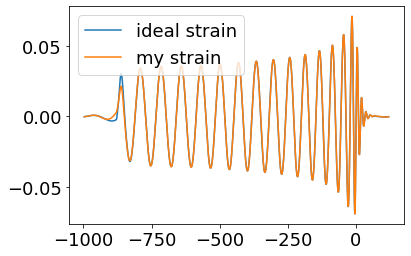

In [272]:
plt.figure()
plt.plot(h3col_t - 997, h3col_hre, label='ideal strain')
# plt.plot(bam_data.times[:-1], np.real(bam_data.hlm_ifft), label='my strain')
plt.plot(bam_data.times, np.real(bam_data.hlm_ifft), label='my strain')
# plt.xlim(-100, 100)
plt.legend()

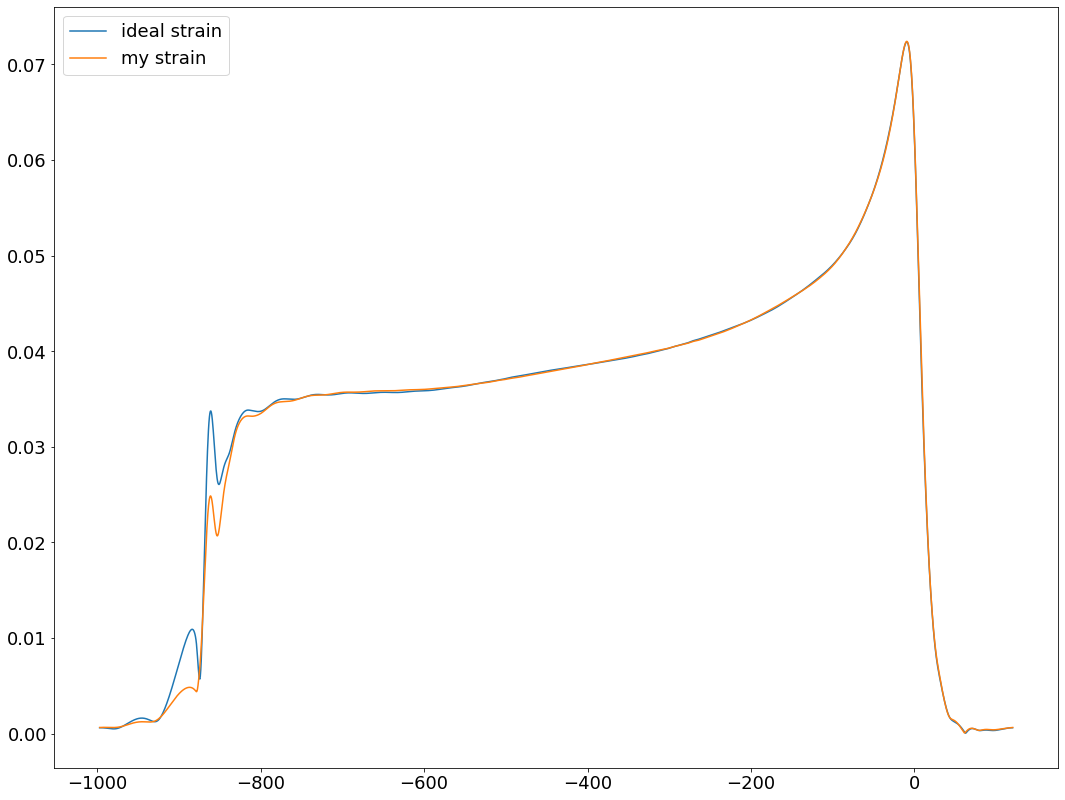

In [273]:
plt.figure(figsize=(18, 14))
plt.plot(h3col_t - 997, np.abs(h3col_hre - 1.j*h3col_him), label='ideal strain')
# plt.plot(bam_data.times[:-1], np.abs(bam_data.hlm_ifft), label='my strain')
plt.plot(bam_data.times, np.abs(bam_data.hlm_ifft), label='my strain')
# plt.xlim(-100, 100)
plt.legend()

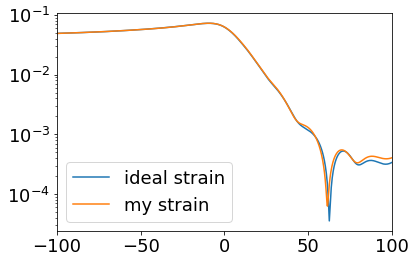

In [332]:
plt.figure()
plt.plot(h3col_t - 997, np.abs(h3col_hre - 1.j*h3col_him), label='ideal strain')
# plt.plot(bam_data.times[:-1], np.abs(bam_data.hlm_ifft), label='my strain')
plt.plot(bam_data.times, np.abs(bam_data.hlm_ifft), label='my strain')
plt.xlim(-100, 100)
plt.legend()
plt.yscale('log')

(-600, 100)

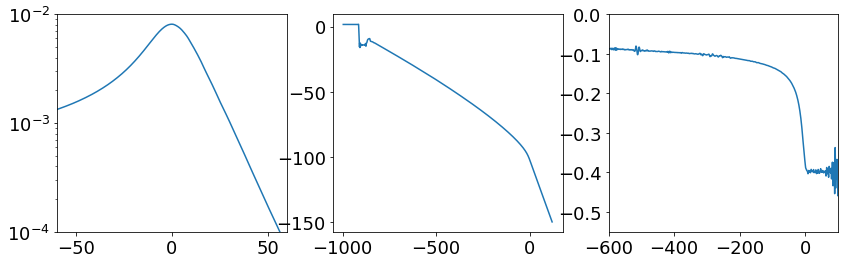

In [275]:

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(bam_data.times, bam_data.amp)
axes[0].set_yscale('log')
axes[0].set_xlim(-60,60)
axes[0].set_ylim(1e-4,1e-2)

axes[1].plot(bam_data.times, bam_data.phi)

axes[2].plot(bam_data.times, bam_data.phase_derivative)
axes[2].set_ylim(-0.55, 0)
axes[2].set_xlim(-600, 100)

In [390]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2, bbh_file=None):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        
        self.bbh_file = bbh_file

        if 'SXS' in self.nrfile:
            self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
        else:
            self.nrdata = Load_BAM_data(nrfile=self.nrfile, bbh_file=self.bbh_file, npts=self.npts_time, t1=self.t1, t2=self.t2)
            self.nrdata.compute_strain_ffi(om_zero=None)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.3f}".format(self.nrdata.q))
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)
        
        self.hlm_phase = np.unwrap(np.angle(self.nrdata.hlm))
        i_hlm_phase = IUS(self.nrdata.times, self.hlm_phase)
        self.hlm_ang_freq = i_hlm_phase.derivative()(self.nrdata.times)
        self.hlm_amp = np.abs(self.nrdata.hlm)
        
        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        self.psi4lm_amp = np.abs(self.psi4lm)
        
        # index of maximum
        max_idx = self.psi4lm_amp.argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
#         self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        
    
    
        # time shift between peak of strain and peak of psi4
        # index of maximum
        hlm_max_idx = self.hlm_amp.argmax()
        # time of maximum
        self.hlm_time_at_max_idx = self.nrdata.times[hlm_max_idx]

# lmfit lorentzian amplitude

In [391]:
# # get data
# nrfiles = dict(
#     q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
#     q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
#     q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
#     q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
#     q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5'
# )

# get data
nrfiles = dict(
    q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
    q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
    q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
    q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
    q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
    q18='/Users/spx8sk/work/data/q18a0a0c025_144/psi3col.r7.l5.l2.m2'
)

In [392]:
nrfiles['q1']

'/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5'

In [393]:
ell = 2
mm = 2

npts_time = 1000*2
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
# t1=-600
t1=-1000
# t1=-800
t2=80


In [394]:
psi4s = {}
for k,v in list(nrfiles.items()):
    psi4s.update({k:Psi4(v, ell, mm, npts_time,t1=t1,t2=t2)})

In [395]:
# bbh_file = "/Users/spx8sk/work/data/q18a0a0c025_144/q18a0a0c025_144.bbh"
# bam_file = "/Users/spx8sk/work/data/q18a0a0c025_144/psi3col.r9.l4.l2.m2"

# bam_data = Load_BAM_data(nrfile=bam_file, bbh_file=bbh_file, npts=npts_time)

# psi4s.update({
#     'q18':Psi4(bam_file, 2, 2, npts_time, t1=t1, t2=t2, bbh_file=bbh_file)
# })

In [396]:
for k in psi4s.keys():
    print(1./psi4s[k].fdamp/2/np.pi)

11.706422641558191
11.554740530290251
11.36516841490208
11.32930696199893
11.272552160962043
11.255711435422901


Text(0.5, 1.0, '$|h|(t)$')

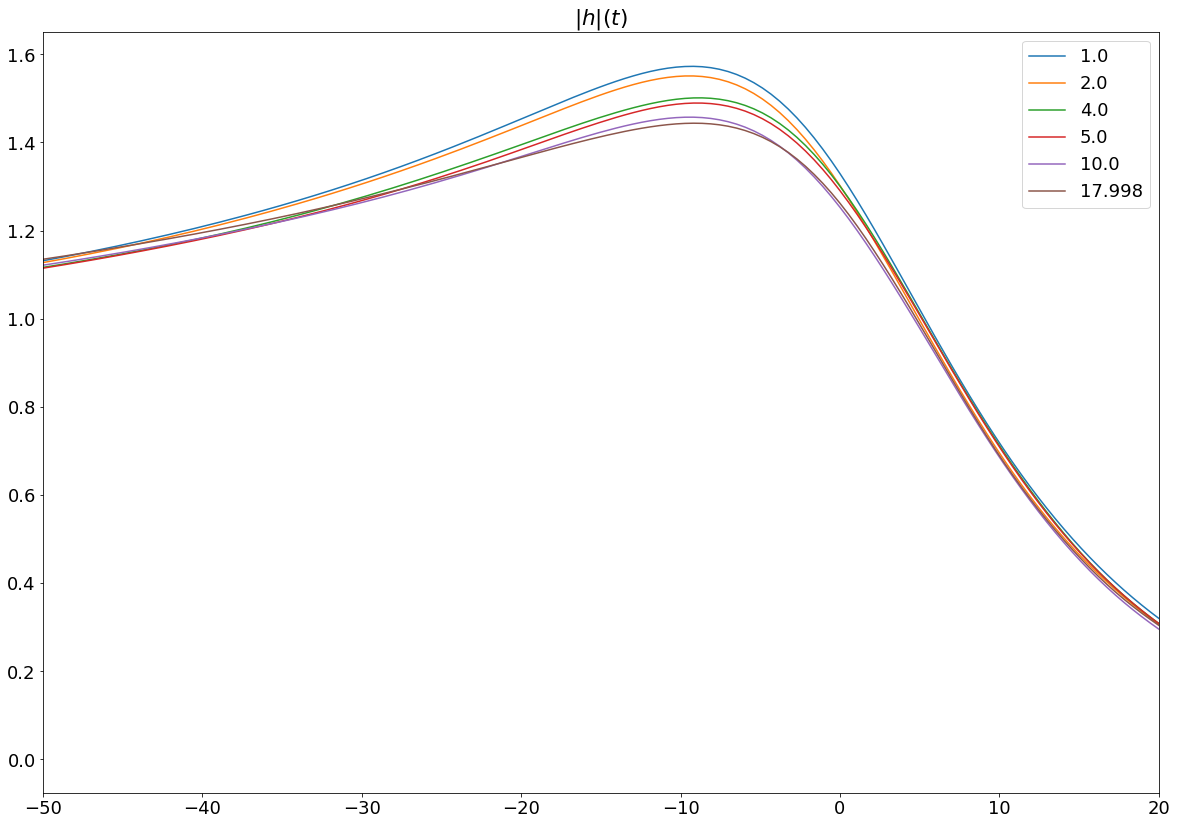

In [412]:
plt.figure(figsize=(20, 14))
for k in psi4s.keys():
    
#     plt.plot(psi4s[k].nrdata.times, psi4s[k].hlm_amp / psi4s[k].eta, label=psi4s[k].q)
    plt.plot(psi4s[k].times, psi4s[k].hlm_amp / psi4s[k].eta, label=psi4s[k].q)
plt.legend()
plt.xlim(-50,20)
# plt.yscale('log')
plt.title(r'$|h|(t)$')

Text(0.5, 1.0, '$|\\Psi_4|(t)$')

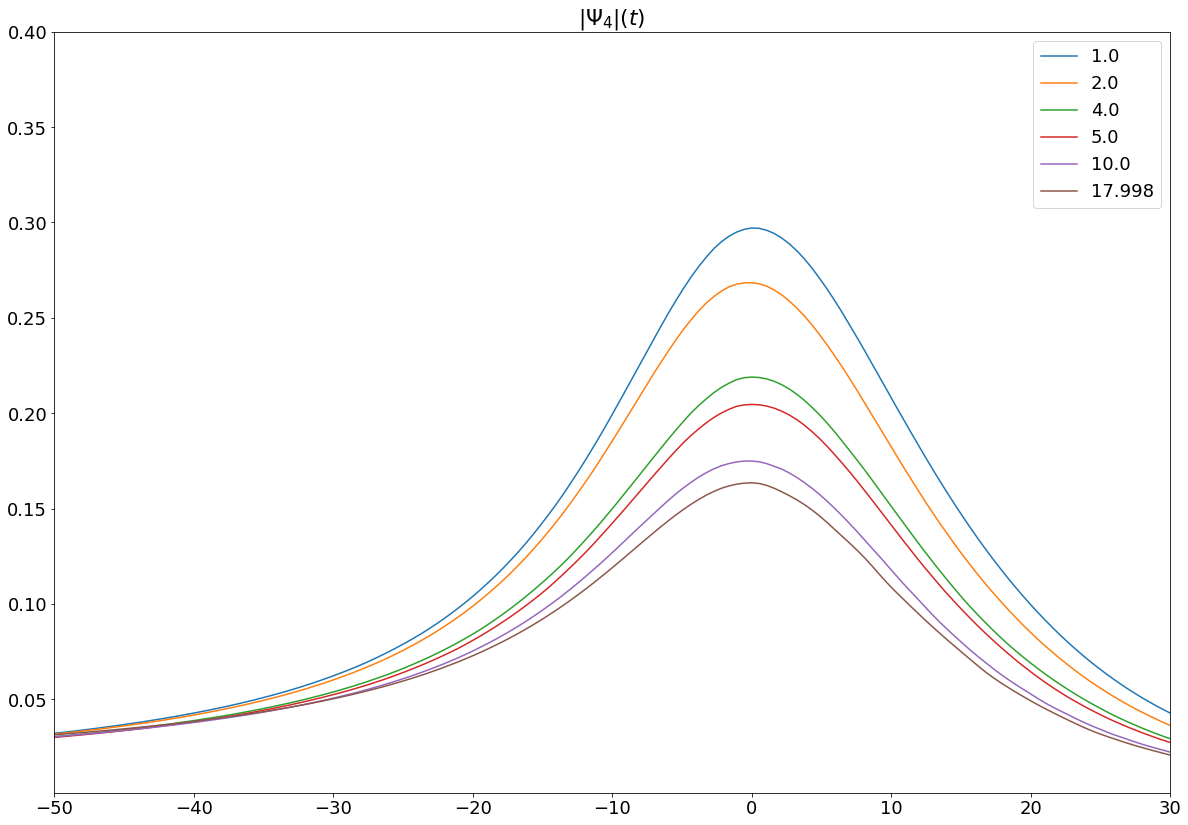

In [379]:
plt.figure(figsize=(20, 14))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].eta, label=psi4s[k].q)
    
# plt.plot(bam_data.times, bam_data.amp / bam_data.eta, label='q18')

plt.legend()
plt.xlim(-50,30)
plt.ylim(1e-3, 0.4)
# plt.yscale('log')
plt.title(r'$|\Psi_4|(t)$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $\\Psi_4$')

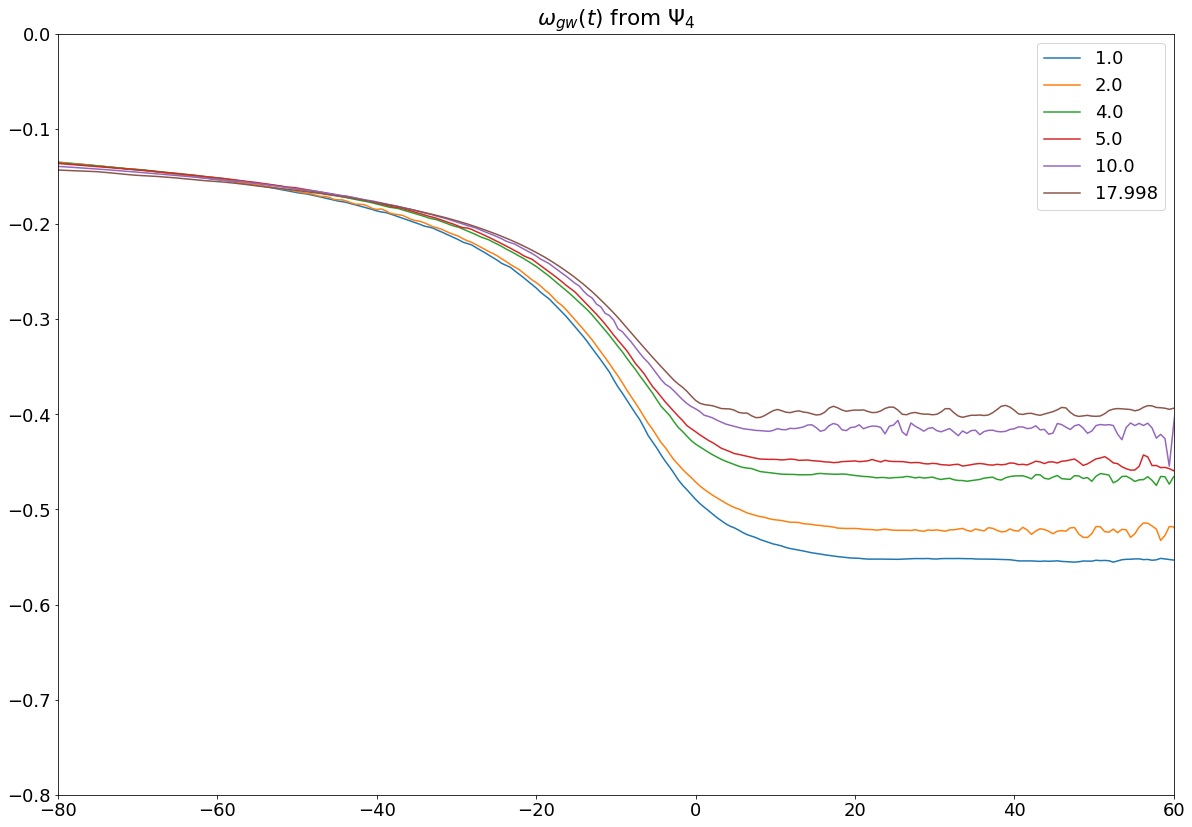

In [380]:
plt.figure(figsize=(20, 14))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_ang_freq, label=psi4s[k].q)
    
# plt.plot(bam_data.times, bam_data.phase_derivative, label='q18')
    
    
plt.legend()
plt.xlim(-80,60)
plt.ylim(-0.8,0)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $\Psi_4$')

In [443]:
# difference between psi4 peak and strain peak
for k in psi4s.keys():
    
    # strain
    # index of maximum
    max_idx_strain = psi4s[k].hlm_amp.argmax()
    max_idx_psi4 = psi4s[k].psi4lm_amp.argmax()
    
    
    # time of maximum
    time_at_max_idx_strain = psi4s[k].times[max_idx_strain]
    time_at_max_idx_psi4 = psi4s[k].times[max_idx_psi4]

    diff = time_at_max_idx_strain - time_at_max_idx_psi4
    
    print("{}: diff = {}".format(k, diff))
    

q1: diff = -9.18459229614814
q2: diff = -9.18459229614814
q4: diff = -8.644322161080595
q5: diff = -9.18459229614814
q10: diff = -9.18459229614814
q18: diff = -9.184592296148026


# check |h|  \sim |psi4|/ omega^2

In [381]:
# pretty good

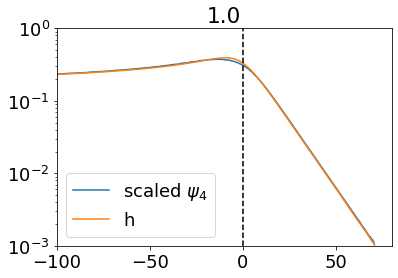

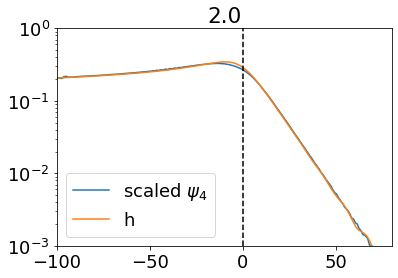

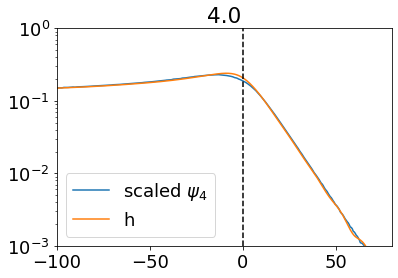

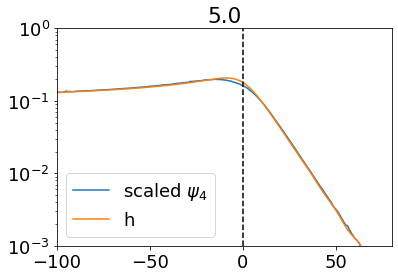

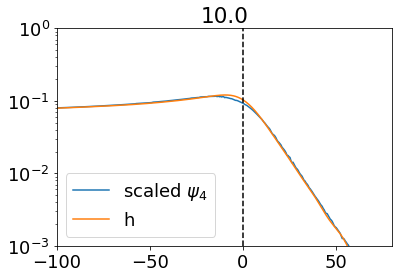

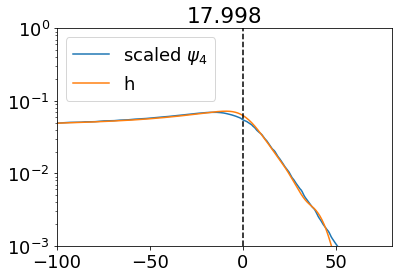

In [432]:
for k in psi4s.keys():
    
#     times = psi4s[k].nrdata.times # time from strain
    times = psi4s[k].times # time from psi4
    
    plt.figure()
    plt.plot(times, psi4s[k].psi4lm_amp / psi4s[k].psi4lm_ang_freq / psi4s[k].psi4lm_ang_freq, label="scaled " + "$\psi_4$")
    plt.plot(times, psi4s[k].hlm_amp, label='h')

    
    plt.legend()
    plt.xlim(-100,80)
    plt.ylim(1e-3,1)
    plt.yscale('log')
    plt.title(psi4s[k].q)
    plt.axvline(0., c='k', ls='--')

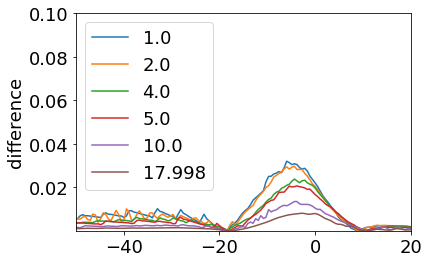

In [433]:
data_residuals = {}

plt.figure()
for k in psi4s.keys():
    
#     times = psi4s[k].nrdata.times # time from strain
    times = psi4s[k].times # time from psi4
    
    h = psi4s[k].hlm_amp
    p = psi4s[k].psi4lm_amp / psi4s[k].psi4lm_ang_freq / psi4s[k].psi4lm_ang_freq
    
#     res = np.abs(100 * ((h - p) / h))
    res = np.abs(((h - p)))
    data_residuals.update({k:res})
    

#     plt.plot(psi4s[k].nrdata.times, res, label=psi4s[k].q)
    plt.plot(times, res, label=psi4s[k].q)
    
    plt.legend()
#     plt.yscale('log')
    plt.xlim(-50,20)
#     plt.yscale('log')
    plt.ylabel("difference")
    plt.ylim(1e-4,0.1)

In [434]:
data_residuals.keys()

dict_keys(['q1', 'q2', 'q4', 'q5', 'q10', 'q18'])

working: q1
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 46
    # variables        = 2
    chi-square         = 2.6976e-04
    reduced chi-square = 6.1309e-06
    Akaike info crit   = -550.144809
    Bayesian info crit = -546.487526
[[Variables]]
    A:      0.03046754 +/- 6.3591e-04 (2.09%) (init = 10)
    t0:    -5.71206108 +/- 0.24228391 (4.24%) (init = -5)
    gamma:  5.853211 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, t0) = -0.371


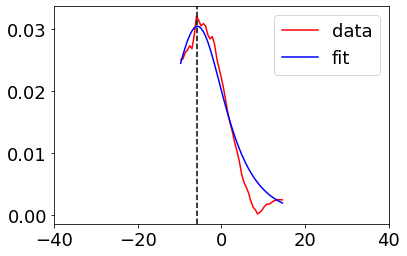

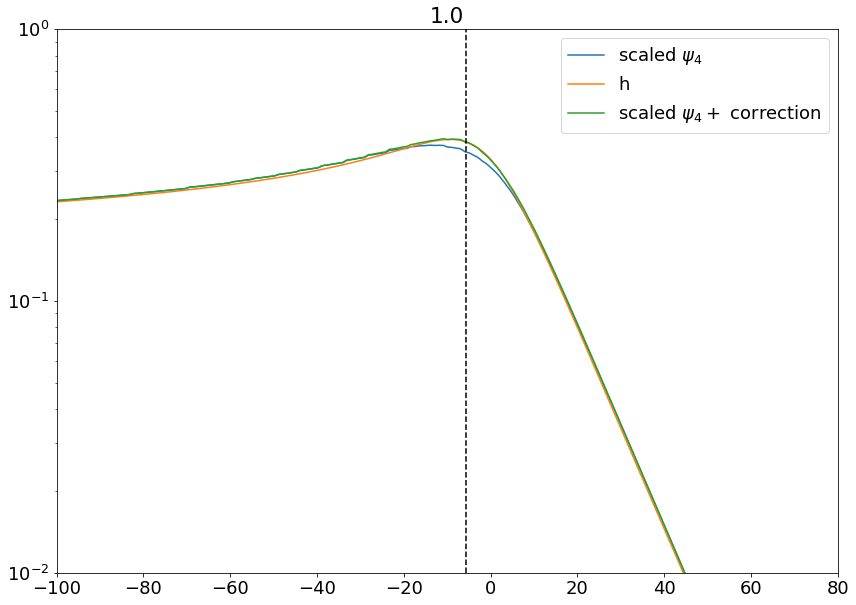

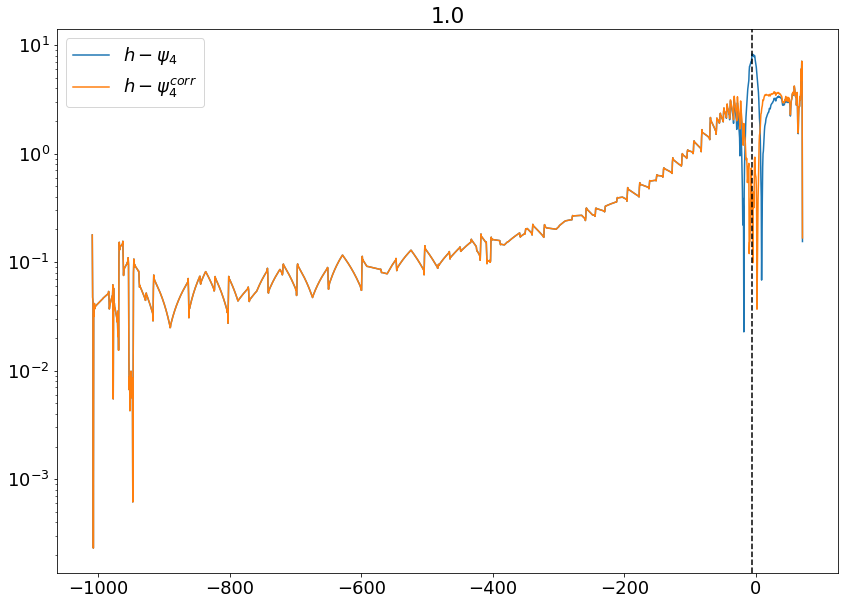

working: q2
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 46
    # variables        = 2
    chi-square         = 1.8192e-04
    reduced chi-square = 4.1345e-06
    Akaike info crit   = -568.267803
    Bayesian info crit = -564.610520
[[Variables]]
    A:      0.02879831 +/- 5.1732e-04 (1.80%) (init = 10)
    t0:    -5.55963688 +/- 0.20502408 (3.69%) (init = -5)
    gamma:  5.77737 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, t0) = -0.348


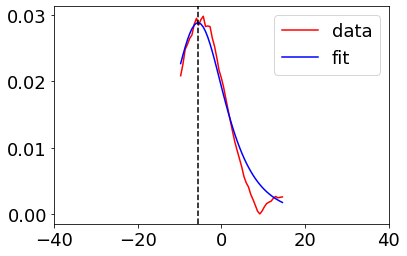

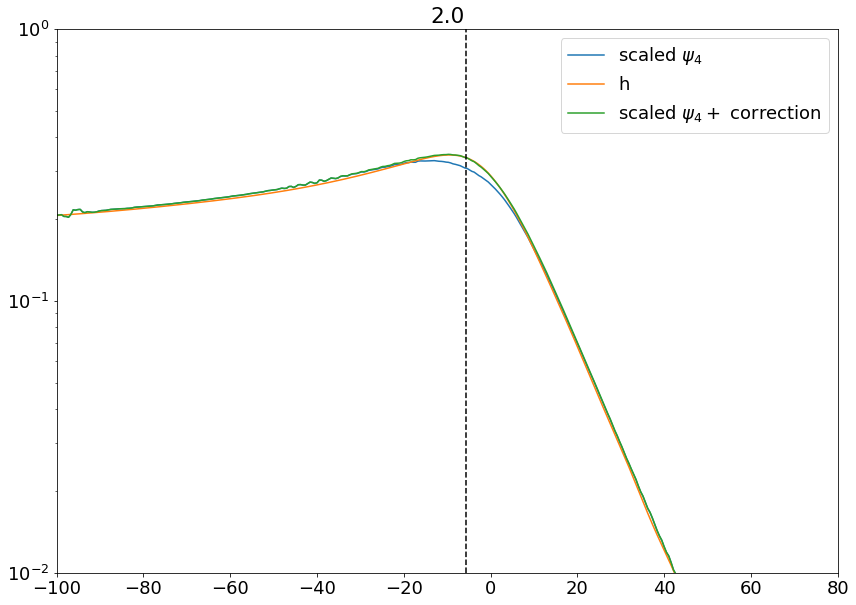

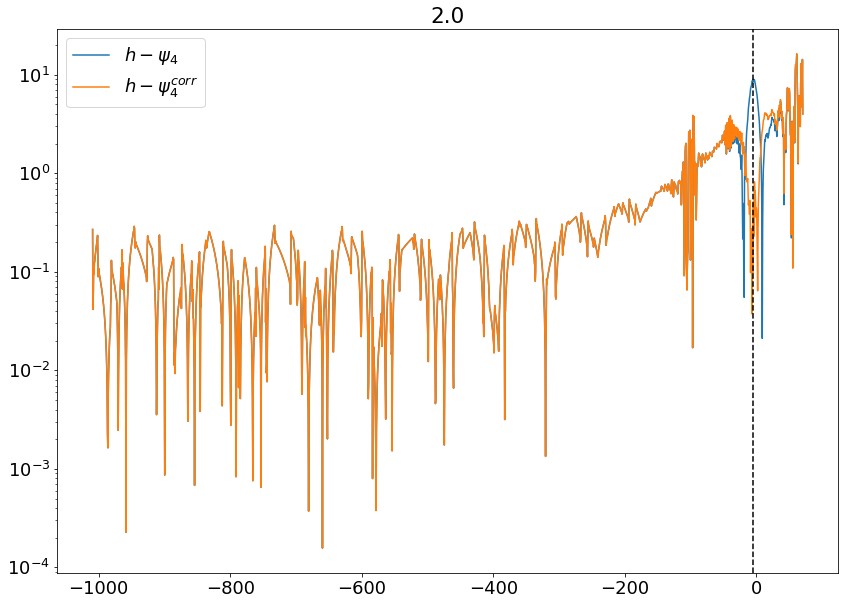

working: q4
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 46
    # variables        = 2
    chi-square         = 1.2213e-04
    reduced chi-square = 2.7756e-06
    Akaike info crit   = -586.598635
    Bayesian info crit = -582.941353
[[Variables]]
    A:      0.02273283 +/- 3.9522e-04 (1.74%) (init = 10)
    t0:    -4.15438744 +/- 0.18879594 (4.54%) (init = -5)
    gamma:  5.682584 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, t0) = -0.214


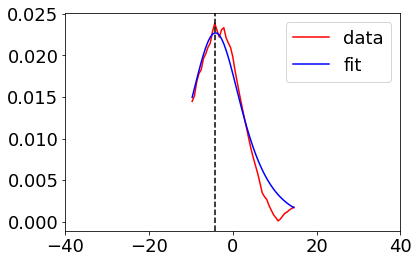

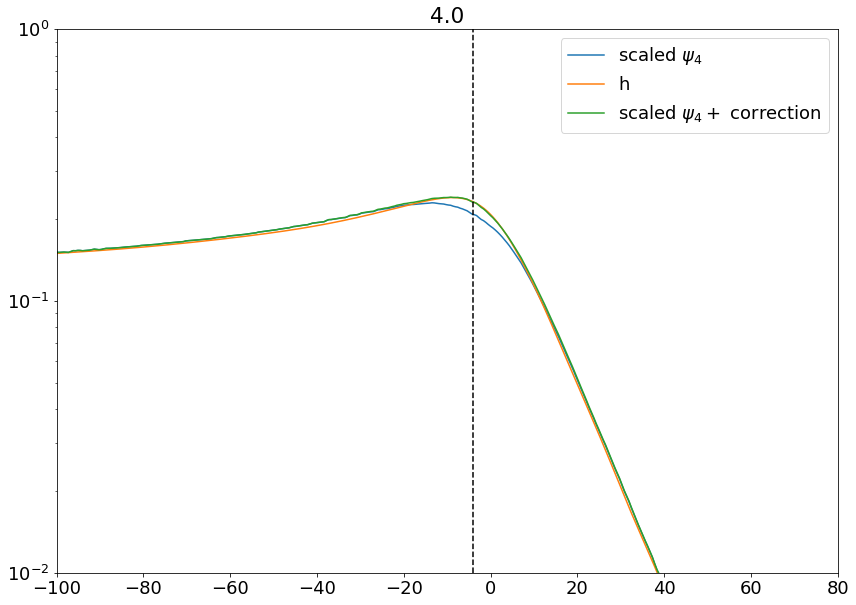

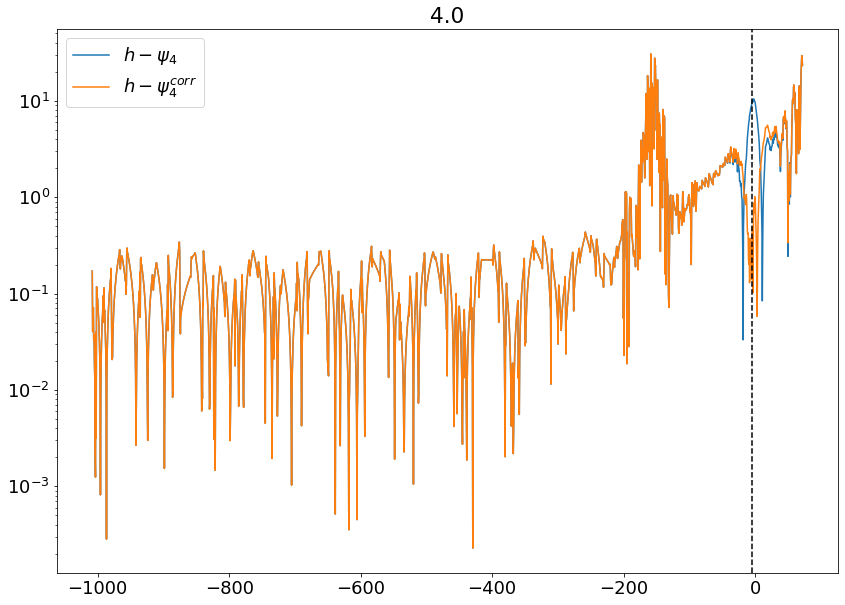

working: q5
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 46
    # variables        = 2
    chi-square         = 6.4246e-05
    reduced chi-square = 1.4601e-06
    Akaike info crit   = -616.145541
    Bayesian info crit = -612.488258
[[Variables]]
    A:      0.02046918 +/- 2.8685e-04 (1.40%) (init = 10)
    t0:    -4.14770314 +/- 0.15160428 (3.66%) (init = -5)
    gamma:  5.664653 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, t0) = -0.213


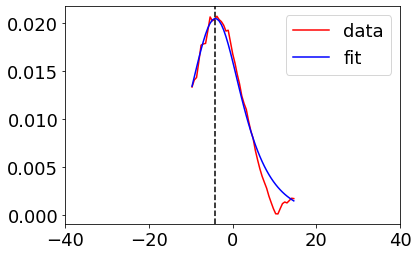

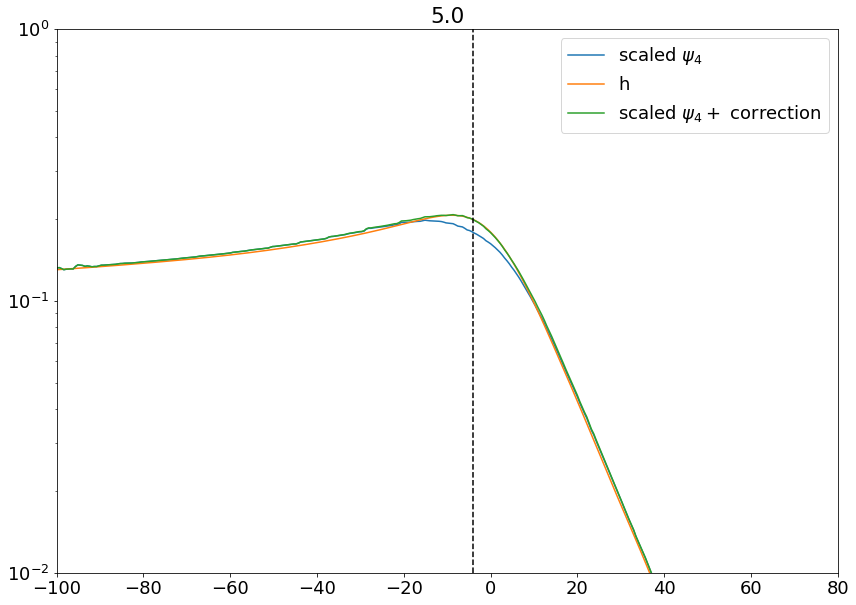

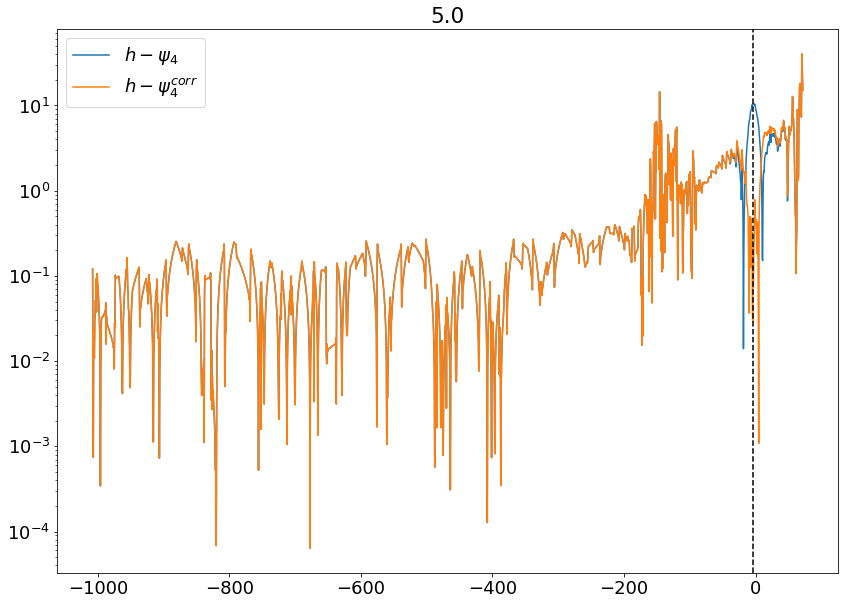

working: q10
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 46
    # variables        = 2
    chi-square         = 2.4694e-05
    reduced chi-square = 5.6123e-07
    Akaike info crit   = -660.128743
    Bayesian info crit = -656.471460
[[Variables]]
    A:      0.01301368 +/- 1.7752e-04 (1.36%) (init = 10)
    t0:    -4.05426138 +/- 0.14640448 (3.61%) (init = -5)
    gamma:  5.636276 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, t0) = -0.204


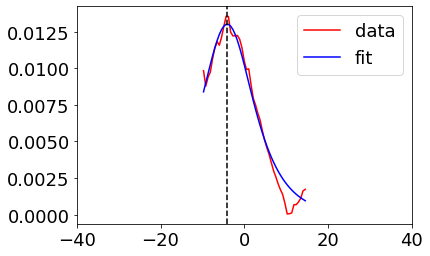

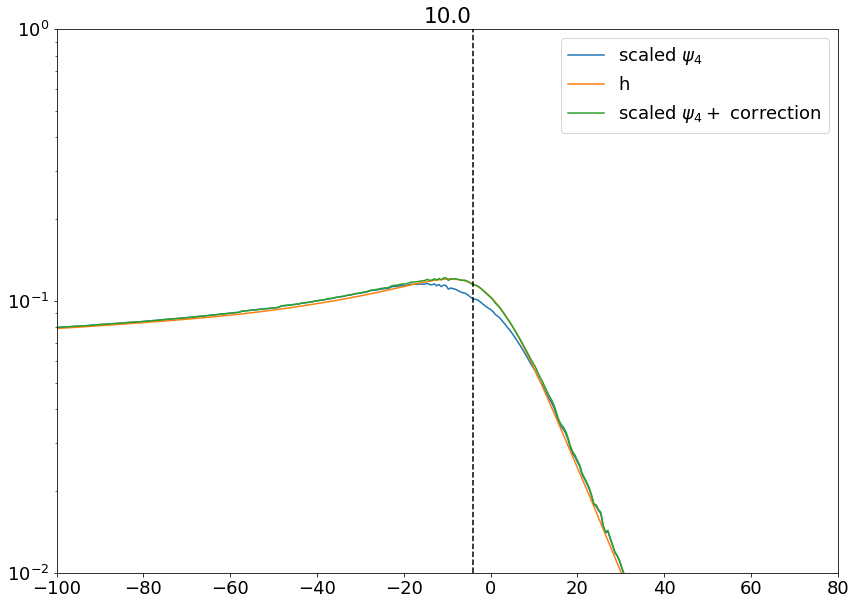

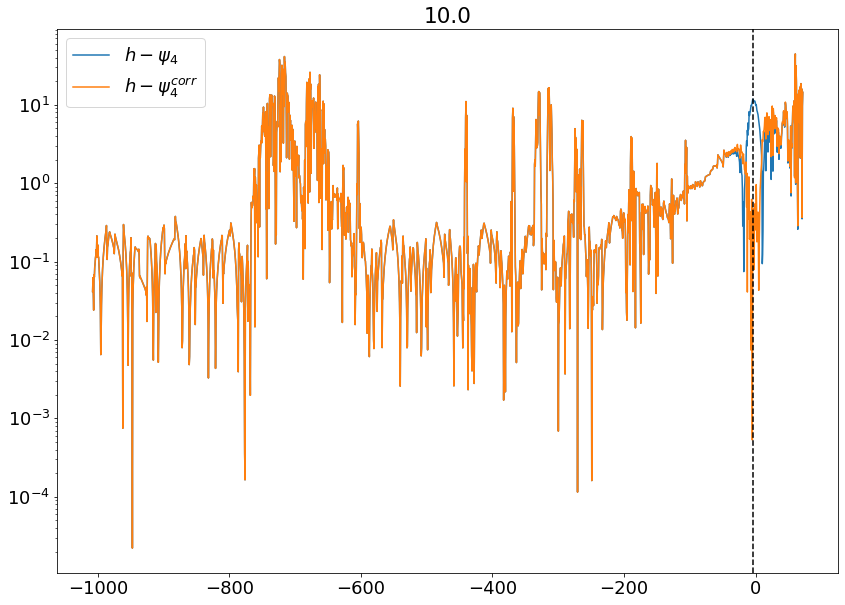

working: q18
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 46
    # variables        = 2
    chi-square         = 1.3690e-05
    reduced chi-square = 3.1114e-07
    Akaike info crit   = -687.263177
    Bayesian info crit = -683.605894
[[Variables]]
    A:      0.00814389 +/- 1.2921e-04 (1.59%) (init = 10)
    t0:    -3.22864924 +/- 0.16695348 (5.17%) (init = -5)
    gamma:  5.627856 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, t0) = -0.152


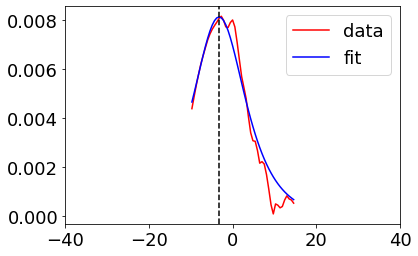

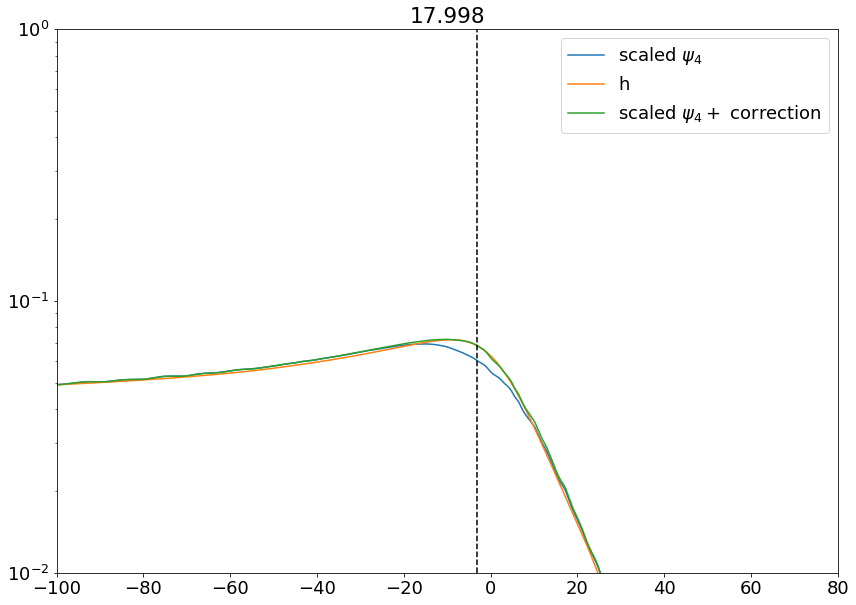

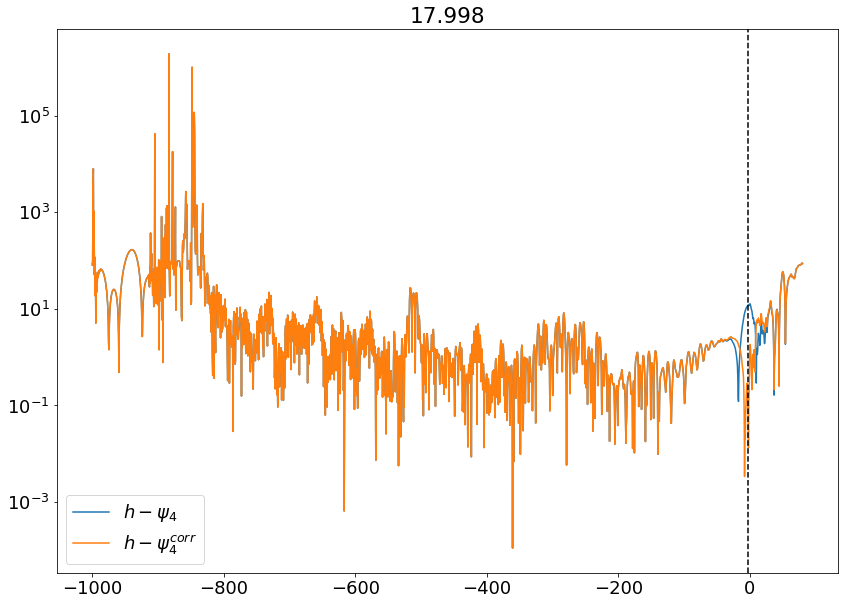

In [528]:
from lmfit import Parameters, minimize
from lmfit.printfuncs import report_fit

def residual(pars, x, data=None):
    
    A = pars['A']
    t0 = pars['t0']
    gamma = pars['gamma']
    
    sech = 1/np.cosh( (t0 - x) / gamma )
    model = A * sech

    if data is None:
        return model
    return model - data




out_all_q = {}

for k in psi4s.keys():
    print('working: {}'.format(k))


    # times = psi4s[k].nrdata.times # time from strain
    times = psi4s[k].times # time from psi4

    x_pre = times

    # mask = (x_pre > -20) & (x_pre < 20)
    mask = (x_pre > -10) & (x_pre < 15)

    x = x_pre[mask]
    data = data_residuals[k][mask]

    fit_params = Parameters()

    fit_params.add('A', value=10, min=0.0001, max=20)
    # fit_params.add('t0', value=3, min=-20, max=20)
    # fit_params.add('t0', value=-10/2, min=-20, max=20, vary=False)
    fit_params.add('t0', value=-10/2, min=-20, max=20, vary=True)

    gamma = 1./psi4s[k].fdamp/2/np.pi

    fit_params.add('gamma', value=gamma/2, min=1, max=30, vary=False)

    out = minimize(residual, fit_params, args=(x,), kws={'data': data})
    fit = residual(out.params, x)
    
    out_all_q.update({
        k:{
            'out':out,
            'q':psi4s[k].q,
            'eta':psi4s[k].eta
        }
    })
    

    report_fit(out, show_correl=True)

    plt.plot(x, data, 'r', label='data')
    plt.plot(x, fit, 'b', label='fit')
    plt.xlim(-40,40)
    plt.legend()
    plt.axvline(out.params['t0'], c='k', ls='--')
    plt.show()
    plt.close()



    # add the correction to the approximation

    correction = residual(out.params, times)

    plt.figure(figsize=(14,10))

    plt.plot(times, psi4s[k].psi4lm_amp / psi4s[k].psi4lm_ang_freq / psi4s[k].psi4lm_ang_freq, label="scaled " + "$\psi_4$")
    plt.plot(times, psi4s[k].hlm_amp, label='h')
    plt.plot(times, psi4s[k].psi4lm_amp / psi4s[k].psi4lm_ang_freq / psi4s[k].psi4lm_ang_freq + correction, label="scaled " + "$\psi_4 + $ correction")

    plt.legend()
    plt.xlim(-100,80)
    plt.ylim(1e-2,1)
    plt.yscale('log')
    plt.title(psi4s[k].q)
    plt.axvline(out.params['t0'], c='k', ls='--')
    plt.show()
    plt.close()

    plt.figure(figsize=(14,10))

    h = psi4s[k].hlm_amp
    p4 = psi4s[k].psi4lm_amp / psi4s[k].psi4lm_ang_freq / psi4s[k].psi4lm_ang_freq
    p4_corr = p4 + correction

    plt.plot(times, np.abs(100*(h - p4)/h), label='$h - \psi_4$')
    plt.plot(times, np.abs(100*(h - p4_corr)/h), label='$h - \psi_4^{corr}$')

    plt.legend()
    # plt.xlim(-100,80)
    # plt.ylim(1e-2,1)
    plt.yscale('log')
    plt.title(psi4s[k].q)
    plt.axvline(out.params['t0'], c='k', ls='--')
    plt.show()
    plt.close()

In [529]:
out_all_q

{'q1': {'out': <lmfit.minimizer.MinimizerResult at 0x1a3a1bd1d0>,
  'q': 1.0,
  'eta': 0.25},
 'q2': {'out': <lmfit.minimizer.MinimizerResult at 0x1a3aec9290>,
  'q': 2.0,
  'eta': 0.22222233610069422},
 'q4': {'out': <lmfit.minimizer.MinimizerResult at 0x1a3b74f510>,
  'q': 4.0,
  'eta': 0.16000030249558175},
 'q5': {'out': <lmfit.minimizer.MinimizerResult at 0x1a345d0e50>,
  'q': 5.0,
  'eta': 0.13888911125870543},
 'q10': {'out': <lmfit.minimizer.MinimizerResult at 0x1a2e7d9410>,
  'q': 10.0,
  'eta': 0.08264502420740191},
 'q18': {'out': <lmfit.minimizer.MinimizerResult at 0x1a34c9b810>,
  'q': 17.998,
  'eta': 0.04986613903727723}}

In [530]:
out_all_q['q1']['out'].params

Parameters([('A',
             <Parameter 'A', value=0.030467543863976054 +/- 0.000636, bounds=[0.0001:20]>),
            ('t0',
             <Parameter 't0', value=-5.712061075873947 +/- 0.242, bounds=[-20:20]>),
            ('gamma',
             <Parameter 'gamma', value=5.853211320779096 (fixed), bounds=[1:30]>)])

In [531]:
out_all_q['q1']['q']

1.0

In [532]:
# plot across parameter space

In [533]:
out_all_q['q1']['out'].params.keys()

odict_keys(['A', 't0', 'gamma'])

In [534]:
out_all_q['q1']['out'].params['A'].vary

True

In [535]:
out_all_q['q1']['out'].params['A'].name

'A'

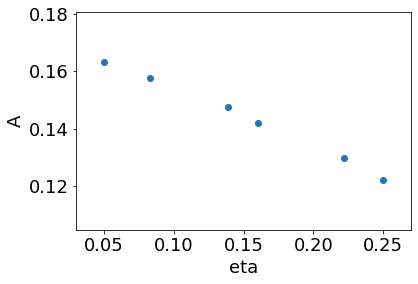

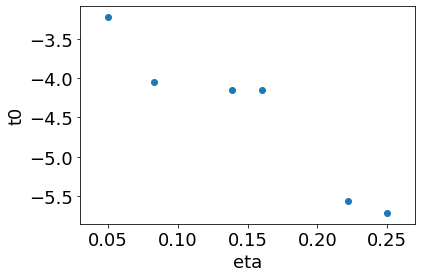

In [546]:
for p in out_all_q['q1']['out'].params.keys():
#     qs = np.array([out_all_q[k]['q'] for k in out_all_q.keys()])
    etas = np.array([out_all_q[k]['eta'] for k in out_all_q.keys()])
    
    pd = out_all_q['q1']['out'].params
    if pd[p].vary:

        ys = np.array([out_all_q[q]['out'].params[p].value for q in out_all_q.keys()])
        plt.figure()
        if pd[p].name == 'A':
#             plt.scatter(etas, ys)
#             plt.scatter(etas, ys*etas)
            plt.scatter(etas, ys/etas)
        else:
            plt.scatter(etas, ys)
        
        plt.xlabel('eta')
        plt.ylabel(pd[p].name)